# ***Uproot_B_Tau_Nu_analysis_Tomas_Version***

This Notebook contents the analysis for 3 different signals and 2 background simultions of the final state $B, \tau, \nu$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import awkward
import mplhep as hep
hep.set_style(hep.style.CMS)

<ipython-input-1-89f9c628b0f9>:7: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style(hep.style.CMS)


# ***Class Declaration: Making the Dataframe***

In [2]:
class RootTreeReader:

  """ 
  Read data from a ROOT TTree 
  Parameters:
  path : string
      Path to the ROOT file
  tree_name : string (default=Delphes)
      Name of the ROOT TTree
  Attributes:
    tree: Root TTree 
  """

  def __init__(self, path: str, tree_name: str = "Delphes"):
    self.tree = uproot.open(path)[tree_name]


  def get_branches(self, branches = ["MissingET.MET",
                        "MissingET.Eta",
                        "MissingET.Phi",
                        "Jet.PT",
                        "Jet.Eta",
                        "Jet.Phi",
                        "Jet.Mass",
                        "Jet.TauTag",
                        "Jet.BTag",
                        "Jet_size"], max_elements=4):
    """
    returns a DataFrame with branches as features
    branches : array-like
      branches to load from the ROOT tree
    max_elements : int (default=4)
      maximum number of elements to load from jagged arrays
    """   
    self._max_elements = max_elements
    self._df = pd.DataFrame(index=range(self.tree.num_entries))

    for branch in branches:
      self._join_branch(branch)

    return self._set_columns_names(self._df)


  def _join_branch(self, branch):
    """joins a branch to self._df"""
    df = self.tree.arrays(branch, library="pd")

    if "." in branch:
      if len(df) > len(df.groupby(level=0).size()):
        self._add_jagged_branch(df, branch)
      else:
        self._add_branch(df, branch)
    else:
      self._add_branch(df, branch)


  def _add_branch(self, df, branch: str):
    """adds a non-jagged branch to self.df"""
    self._df[branch] = self.tree[branch].array(library="pd").values


  def _add_jagged_branch(self, df, branch):
    """adds a jagged branch to self.df"""
    df = df.unstack().iloc[:,:self._max_elements]
    df.columns = [f"{branch}{i}" for i in range(self._max_elements)]
    self._df = self._df.join(df)

  @staticmethod
  def _set_columns_names(df):
    df.columns = df.columns.str.lower().str.replace(".","_")
    return df


def build_df(path):
  """
  Generates a Dataframe from the root in "path"
  """
  reader = RootTreeReader(path)
  df = reader.get_branches()
  df["n_b"]  =  reader.tree.arrays("Jet.BTag", library="pd").sum(level=0)
  df["n_tau"] = reader.tree.arrays("Jet.TauTag", library="pd").sum(level=0)
  return df

In [3]:
# Cut for events with at least 1 tau
def tau_cut(df, val = 0):
  mask = (df.n_tau > val) & (df.jet_tau_index >= 0)
  return df.loc[mask]

def b_cut(df, val = 0):
  mask = (df.n_b > val) & (df.jet_b_index >= 0)
  return df.loc[mask]


#Cuts over the final Df

def pt_tau_cut(df, val = 25):
  # leading jets pt > 30 GeV
  mask = df.tau_pT > val
  return df.loc[mask]


def pt_b_cut(df, val = 30):
  # leading jets pt > 30 GeV
  mask = df.b_pT > val
  return df.loc[mask]


def eta_tau_cut(df, val = 2.4):
  # leading jets eta < 2.4
  mask = np.abs(df.tau_eta) < val
  return df.loc[mask]


def eta_b_cut(df, val = 2.1):
  # leading jets eta < 2.4
  mask = np.abs(df.b_eta) < val
  return df.loc[mask]


def phi_tau_cut(df, val= 2.0):
  # delta phi between met and tau > 2.0
  mask = np.abs(df.Delta_phi_Tau_Met) > val
  return df.loc[mask]


def et_met_cut(df, val = 200):
  # Met et greater than 200
  mask = df.met_Met > val
  return df.loc[mask]


def final_cuts(df, pt_tau = 25, pt_b = 30, eta_tau = 2.4, eta_b = 2.4, met = 150, del_phi = 1.0):
  cut_df = df.copy()
  cut_df = pt_tau_cut(cut_df, pt_tau)
  cut_df = pt_b_cut(cut_df, pt_b)
  cut_df = eta_tau_cut(cut_df, eta_tau)
  cut_df = phi_tau_cut(cut_df, del_phi)
  cut_df = eta_b_cut(cut_df, eta_b)
  cut_df = et_met_cut(cut_df, met)
  return cut_df


def branch_index(df, branch):
  """
  Adds a column with the index of the first jet tagged as branch to the df.

  Branch:
    takes values of "jet_btag" or "jet_tautag"
  
  Ex:
    branch_index(cut_df, "jet_tautag")
    Returns a df with a column with the first jet tagged as tau per ivent
  """
  branch_jets = df[[f"{branch}{i}" for i in range(4)]].copy()

  # events with branch jets
  branch_events = branch_jets[branch_jets.sum(axis=1) > 0]

  # index of first branch jet
  branch_index = branch_events.apply(lambda x: x > 0).apply(lambda x: np.nonzero(x.values)[0][0], axis=1)

  # index of non branch jets (set to nan)
  branch_nan = pd.DataFrame(index= branch_jets[branch_jets.sum(axis=1) == 0].index)

  # branch jet index
  df[f"{branch}_index".replace('tag','')] = pd.concat([branch_index,branch_nan]).sort_index()

  return df , branch_index


def DeltaPhi(row, col1 = 'tau_phi', col2 = 'met_Phi'):
  """
  correction on azimuthal angle difference dphi
  """
  dphi = row[col1] - row[col2]
  if dphi >= np.pi: 
     dphi -= 2*np.pi
  if dphi < -np.pi:
    dphi += 2*np.pi

  return dphi


def DeltaPhi2(dphi):
  """
  correction on azimuthal angle difference dphi
  """
  dphi = phi1 - phi2
  if dphi >= np.pi: 
     dphi -= 2*np.pi
  if dphi < -np.pi:
    dphi += 2*np.pi


def m_Tot(row):  
  #Calculates TotalMass from 5.4  https://arxiv.org/pdf/1709.07242.pdf   
  pt1 = row['tau_pT']
  px1 = row['tau_pT'] * np.cos(row['tau_phi'])
  py1 = row['tau_pT'] * np.sin(row['tau_phi'])
  pt2 = row['b_pT']
  px2 = row['b_pT'] * np.cos(row['b_phi'])
  py2 = row['b_pT'] * np.sin(row['b_phi'])
  met_pt3 = row['met_Met']
  px3 = met_pt3 * np.cos(row['met_Phi'])
  py3 = met_pt3 * np.sin(row['met_Phi'])

  
  vec1 = np.array([px1 , py1])
  vec2 = np.array([px2 , py2])
  vec3 = np.array([px3 , py3])
  vect_t = vec1 + vec2 + vec3 
  vec_t2 = np.dot(vect_t, vect_t)
  sum_escal = (pt1 + pt2 + met_pt3) **2
  return (sum_escal - vec_t2  ) ** 0.5


def transverse_mass(tau_pt, met_et, deltaphi):
  #Calculates the transverse mass between tau (or any other jet) and the met
  return np.sqrt(2 * tau_pt * met_et * (1 - np.cos(deltaphi)))

def invariant_mass(obj1_pt, obj1_eta, obj2_pt, obj2_eta, deltaphi ):
  #Calculates the invariant mass for 2 different objects
  return np.sqrt(2 * obj1_pt * obj2_pt * (np.cosh(obj1_eta-obj2_eta) - np.cos(deltaphi)))

def Get_Pt_Eta_Phi_Tau_B(row):
  """
  Returns a row with a list of the Pt, Eta, Phi
  of the Taus and B's (in the respective order)
  Needs a column named Tau_b_Tuple.
  """
  n_tau = int(row['jet_tau_index'])
  n_b = int(row['jet_b_index'])

  s = pd.Series(cols)
  s1 = list(s[s.astype(str).str[-1] == str(n_tau)][:4])
  s2 = list(s[s.astype(str).str[-1] == str(n_b)][:4])

  tau_pT = row[str(s1[0])] 
  tau_eta = row[str(s1[1])] 
  tau_phi = row[str(s1[2])] 
  tau_mass = row[str(s1[3])]

  b_pT = row[str(s2[0])] 
  b_eta = row[str(s2[1])] 
  b_phi = row[str(s2[2])] 
  b_mass = row[str(s2[3])]

  met_Met = row['missinget_met']	
  met_Phi = row['missinget_phi']	
  met_Eta = row['missinget_eta']

  return (tau_pT, tau_eta, tau_phi, tau_mass, b_pT, b_eta, b_phi, b_mass, met_Met, met_Phi, met_Eta, n_tau, n_b)


def generate_ploteable_invariant_masses(df1, df2, df3):
  #Generates a series for the transverse masses between tau and MET for each dataframe  
  m1 = invariant_mass(df1.tau_pT, df1.tau_eta, df1.b_pT, df1.b_eta, df1.Delta_phi_Tau_B )
  m2 = invariant_mass(df2.tau_pT, df2.tau_eta, df2.b_pT, df2.b_eta, df2.Delta_phi_Tau_B )
  m3 = invariant_mass(df3.tau_pT, df3.tau_eta, df3.b_pT, df3.b_eta, df3.Delta_phi_Tau_B )
  return m1, m2, m3

def generate_ploteable_tr_tau_nu_masses(df1, df2, df3):
  #Generates a series for the transverse masses between tau and MET for each dataframe  
  m1 = transverse_mass(df1.tau_pT, df1.met_Met, df1.Delta_phi_Tau_Met)
  m2 = transverse_mass(df2.tau_pT, df2.met_Met, df2.Delta_phi_Tau_Met)
  m3 = transverse_mass(df3.tau_pT, df3.met_Met, df3.Delta_phi_Tau_Met)
  return m1, m2, m3

def generate_ploteable_tr_b_nu_masses(df1, df2, df3):
  #Generates a series for the transverse masses between B and MET for each dataframe 
  m1 = transverse_mass(df1.b_pT, df1.met_Met, df1.Delta_phi_B_Met)
  m2 = transverse_mass(df2.b_pT, df2.met_Met, df2.Delta_phi_B_Met)
  m3 = transverse_mass(df3.b_pT, df3.met_Met, df3.Delta_phi_B_Met)
  return m1, m2, m3

def generate_ploteable_total_masses(df1, df2, df3):
  #Generates a series for the total msses between B , tau and MET for each dataframe  
  m1 = df1.apply(m_Tot, axis = 1)
  m2 = df2.apply(m_Tot, axis = 1)
  m3 = df3.apply(m_Tot, axis = 1)
  return m1, m2, m3


def generate_data_b_tau_nu(df):
  """Returns a Dataframe with the information per event
  of the tau_jet and the missin energy.
  The index preserves the index from the original dataframe.
  Arguments:
    df :  dataframe generated with 
    get_braches("MissingET.MET","MissingET.Eta","MissingET.Phi","Jet.PT",
                "Jet.Eta","Jet.Phi","Jet.Mass","Jet.TauTag","Jet.BTag","Jet_size")
          
    Also the dataframe must content a column named as n_tau as the number of taus per event
  Columns : 
    'tau_pT' ,'tau_eta' ,'tau_phi' ,'tau_mass', 'b_pT' ,'b_eta' ,'b_phi' ,'b_mass','met_Met' ,'met_Phi' ,'met_Eta', 'n_tau', 'n_b'.

  """
  cut_df, tau_index = branch_index(df, 'jet_tautag')
  cut_df, tau_index = branch_index(cut_df, 'jet_btag')
  cut_df = tau_cut(cut_df)
  cut_df = b_cut(cut_df)

  s = cut_df.apply(Get_Pt_Eta_Phi_Tau_B, axis = 1)
  Df = pd.DataFrame(s.to_list(), index = s.index, 
                    columns=['tau_pT' ,'tau_eta' ,'tau_phi' ,'tau_mass', 
                             'b_pT' ,'b_eta' ,'b_phi' ,'b_mass',
                             'met_Met' ,'met_Phi' ,'met_Eta' ,'n_tau', 'n_b'])
  
  Df['Delta_phi_Tau_Met'] = Df.apply(DeltaPhi,axis = 1)
  Df['Delta_phi_B_Met'] = Df.apply(DeltaPhi,axis = 1, args=('b_phi', 'met_Phi'))
  Df['Delta_phi_Tau_B'] = Df.apply(DeltaPhi,axis = 1, args=('tau_phi', 'b_phi'))
  Df = Df.copy()[Df.n_tau != Df.n_b]
  return Df

def plot_mass1(labels, colors, lines, mass_type,m1, m2 ,m3, m_bg1, m_bg2, Weights, nbins = 40 ,bins_bg = [30,10]):

  """
  Returns a figure with 3 histograms for the 3 arguments, 
  with nbins number of bins and mass_type as a string for the
  x_axis label
  """
  plt.figure(figsize=(10,7))
  plt.title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=16)

  counts_s1, binss1 = np.histogram(m1, nbins, density=True)
  plt.hist(binss1[:-1], bins = binss1, weights = Weights[0]*counts_s1, color= colors[0], linestyle= lines[0],
           label = labels[0], histtype="step", linewidth = "2", log = True)
  counts_s2, binss2 = np.histogram(m2, nbins, density=True)
  plt.hist(binss2[:-1], bins = binss2, weights = Weights[1]*counts_s2, color= colors[1], linestyle= lines[1],
           histtype="step", linewidth = "2", label = labels[1], log = True)
  counts_s3, binss3 = np.histogram(m3, nbins, density=True)
  plt.hist(binss3[:-1], bins = binss3, weights = Weights[2]*counts_s3, color= colors[2], linestyle= lines[2],
           histtype="step", linewidth = "2", label = labels[2], log = True)
  counts_b1, binsb1 = np.histogram(m_bg1, bins_bg[0], density=True)
  plt.hist(binsb1[:-1], bins = binsb1, weights = Weights[3]*counts_b1, color= colors[3], histtype="stepfilled",
           alpha = 0.7, edgecolor='k', label = labels[3], log = True)
  counts_b2, binsb2 = np.histogram(m_bg2, bins_bg[1], density=True)
  plt.hist(binsb2[:-1], bins = binsb2, weights = Weights[4]*counts_b2, color= colors[4], histtype="stepfilled",
           alpha = 0.7, edgecolor='k', label = labels[4], log = True)
  
  plt.ylabel("Events", fontsize= 17)
  plt.xlabel(mass_type, fontsize= 17)
  plt.xticks(fontsize= 14)
  plt.yticks(fontsize= 14)
  plt.legend(loc ='best', fontsize= 13)
  plt.savefig(f"{mass_type}");

#def plot_Met_ET_Phi1(MET_ET1, MET_ET2, MET_ET3, MET_Phi1, MET_Phi2, MET_Phi3, labels, colors, lines):
def plot_Met_ET_Phi1(df1, df2, df3, bg1, bg2, labels, colors, lines, bins_s, bins_bg):

  """
  Returns a 1 dimentional array with 3 histograms in 2 axis with the information of 
  missing energy in the transverse plane and the angle phi in that plane
  """
  fig, ax = plt.subplots(1, 2, figsize = (14, 6), constrained_layout=True)
  #fig.suptitle(f'Variables del MET', fontsize = 17)
  ax[0].hist(df1.missinget_met, bins = bins_s, histtype="step", density = True, linewidth = "2", 
             color= colors[0], linestyle= lines[0], label = labels[0])
  ax[0].hist(df2.missinget_met, bins = bins_s, histtype="step", density = True, linewidth = "2",
             color= colors[1], linestyle= lines[1], label = labels[1])
  ax[0].hist(df3.missinget_met, bins = bins_s, histtype="step", density = True, linewidth = "2", 
             color= colors[2], linestyle= lines[2], label = labels[2])
  ax[0].hist(bg1.missinget_met, bins = bins_s, histtype="stepfilled", density = True, 
             color= colors[3], label = labels[3], alpha = 0.7, edgecolor='k')
  ax[0].hist(bg2.missinget_met, bins = bins_s,histtype="stepfilled", density = True, 
             color= colors[4], label = labels[4], alpha = 0.7, edgecolor='k')

  ax[1].hist(df1.missinget_phi, bins = bins_s, histtype="step", density = True, linewidth = "2", 
             color= colors[0], linestyle= lines[0], label = labels[0])
  ax[1].hist(df2.missinget_phi, bins = bins_s, histtype="step", density = True, linewidth = "2",
             color= colors[1], linestyle= lines[1], label = labels[1])
  ax[1].hist(df3.missinget_phi, bins = bins_s, histtype="step", density = True, linewidth = "2", 
             color= colors[2], linestyle= lines[2], label = labels[2])
  ax[1].hist(bg1.missinget_phi, bins = bins_s, histtype="stepfilled", density = True, 
             color= colors[3], label = labels[3], alpha = 0.7, edgecolor='k')
  ax[1].hist(bg2.missinget_phi, bins = bins_s, histtype="stepfilled", density = True, 
             color= colors[4], label = labels[4], alpha = 0.7, edgecolor='k')

  ax[0].legend(loc = 'best',fontsize= 13)
  ax[1].legend(loc = 'lower center',fontsize= 13)
  
  ax[0].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)
  ax[1].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)

  ax[0].set_ylabel("a.u.", fontsize= 17)
  ax[0].set_xlabel(f"$MET$", fontsize= 17)
  ax[1].set_ylabel("a.u.", fontsize= 17)
  ax[1].set_xlabel(rf"$\phi$", fontsize= 17)
  fig.savefig('Met_Variables')

    
    
def plot_Met_ET_Phi2(df1, df2, df3, bg1, bg2, labels, colors, lines, bins_s, bins_bg):

  """
  Returns a 1 dimentional array with 3 histograms in 2 axis with the information of 
  missing energy in the transverse plane and the angle phi in that plane
  """
  fig, ax = plt.subplots(1, 2, figsize = (14, 6), constrained_layout=True)
  fig.suptitle(f'Variables del MET', fontsize = 17)
  ax[0].hist(df1.met_Met, bins = bins_s, histtype="step", density = True, linewidth = "2", 
             color= colors[0], linestyle= lines[0], label = labels[0])
  ax[0].hist(df2.met_Met, bins = bins_s, histtype="step", density = True, linewidth = "2",
             color= colors[1], linestyle= lines[1], label = labels[1])
  ax[0].hist(df3.met_Met, bins = bins_s, histtype="step", density = True, linewidth = "2", 
             color= colors[2], linestyle= lines[2], label = labels[2])
  ax[0].hist(bg1.met_Met, bins = bins_bg, histtype="stepfilled", density = True, 
             color= colors[3], label = labels[3], alpha = 0.7, edgecolor='k')
  ax[0].hist(bg2.met_Met, bins = bins_bg,histtype="stepfilled", density = True, 
             color= colors[4], label = labels[4], alpha = 0.7, edgecolor='k')

  ax[1].hist(df1.met_Phi, bins = bins_s, histtype="step", density = True, linewidth = "2", 
             color= colors[0], linestyle= lines[0], label = labels[0])
  ax[1].hist(df2.met_Phi, bins = bins_s, histtype="step", density = True, linewidth = "2",
             color= colors[1], linestyle= lines[1], label = labels[1])
  ax[1].hist(df3.met_Phi, bins = bins_s, histtype="step", density = True, linewidth = "2", 
             color= colors[2], linestyle= lines[2], label = labels[2])
  ax[1].hist(bg1.met_Phi, bins = bins_bg, histtype="stepfilled", density = True, 
             color= colors[3], label = labels[3], alpha = 0.7, edgecolor='k')
  ax[1].hist(bg2.met_Phi, bins = bins_bg, histtype="stepfilled", density = True, 
             color= colors[4], label = labels[4], alpha = 0.7, edgecolor='k')

  ax[0].legend(loc = 'best',fontsize= 13)
  ax[1].legend(loc = 'lower center',fontsize= 13)
  
  ax[0].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)
  ax[1].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)

  ax[0].set_ylabel("a.u.", fontsize= 18)
  ax[0].set_xlabel(f"$MET$", fontsize= 18)
  ax[1].set_ylabel("a.u.", fontsize= 18)
  ax[1].set_xlabel(rf"$\phi$", fontsize= 18)

def plot_pt_eta_phi1(labels, colors, lines, df1, df2, df3, bg1, bg2, i, nbins = 40):
  """
  Returns a 2 dimentional array with 3 histograms in 3 axis with the information of 
  pt eta and phi for an object
  """
  fig, ax = plt.subplots(2, 2, figsize = (14, 12), constrained_layout=True)
  fig.suptitle(f'Variables del jet_{i}', fontsize = 15)
  ax[0,0].hist(df1[f'jet_pt{i}'], bins = nbins, histtype="step", density =True, linewidth = "2", 
               color= colors[0], linestyle= lines[0], label = labels[0])
  ax[0,0].hist(df2[f'jet_pt{i}'], bins = nbins, histtype="step", density =True, linewidth = "2",
               color= colors[1], linestyle= lines[1], label = labels[1])
  ax[0,0].hist(df3[f'jet_pt{i}'], bins = nbins, histtype="step", density =True, linewidth = "2", 
               color= colors[2], linestyle= lines[2], label = labels[2])
  ax[0,0].hist(bg1[f'jet_pt{i}'], bins = nbins, histtype="stepfilled", density =True, 
               color= colors[3], label = labels[3], alpha = 0.7, edgecolor='k')
  ax[0,0].hist(bg2[f'jet_pt{i}'], bins = nbins, histtype="stepfilled", density =True, 
               color= colors[4], label = labels[4], alpha = 0.7, edgecolor='k')
  
  ax[0,1].hist(df1[f'jet_eta{i}'], bins = nbins, histtype="step", density =True, linewidth = "2", 
               color= colors[0], linestyle= lines[0], label = labels[0])
  ax[0,1].hist(df2[f'jet_eta{i}'], bins = nbins, histtype="step", density =True, linewidth = "2",
               color= colors[1], linestyle= lines[1], label = labels[1])
  ax[0,1].hist(df3[f'jet_eta{i}'], bins = nbins, histtype="step", density =True, linewidth = "2", 
               color= colors[2], linestyle= lines[2], label = labels[2])
  ax[0,1].hist(bg1[f'jet_eta{i}'], bins = nbins, histtype="stepfilled", density =True, 
               color= colors[3], label = labels[3], alpha = 0.7, edgecolor='k')
  ax[0,1].hist(bg2[f'jet_eta{i}'], bins = nbins, histtype="stepfilled", density =True, 
               color= colors[4], label = labels[4], alpha = 0.7, edgecolor='k')

  ax[1,0].hist(df1[f'jet_phi{i}'], bins = nbins, histtype="step", density =True, linewidth = "2", 
               color= colors[0], linestyle= lines[0], label = labels[0])
  ax[1,0].hist(df2[f'jet_phi{i}'], bins = nbins, histtype="step", density =True, linewidth = "2",
               color= colors[1], linestyle= lines[1], label = labels[1])
  ax[1,0].hist(df3[f'jet_phi{i}'], bins = nbins, histtype="step", density =True, linewidth = "2", 
               color= colors[2], linestyle= lines[2], label = labels[2])
  ax[1,0].hist(bg1[f'jet_phi{i}'], bins = nbins, histtype="stepfilled", density =True, 
               color= colors[3], label = labels[3], alpha = 0.7, edgecolor='k')
  ax[1,0].hist(bg2[f'jet_phi{i}'], bins = nbins, histtype="stepfilled", density =True, 
               color= colors[4], label = labels[4], alpha = 0.7, edgecolor='k')

  ax[1,1].hist(np.abs(df1.apply(DeltaPhi, axis = 1, args= (f'jet_phi{i}', "missinget_phi"))),
               bins = nbins, histtype="step", density =True, linewidth = "2",
               color= colors[0], linestyle= lines[0], label = labels[0])
  ax[1,1].hist(np.abs(df2.apply(DeltaPhi, axis = 1, args= (f'jet_phi{i}', "missinget_phi"))),
               bins = nbins, histtype="step", density =True, linewidth = "2",
               color= colors[1], linestyle= lines[1], label = labels[1])
  ax[1,1].hist(np.abs(df3.apply(DeltaPhi, axis = 1, args= (f'jet_phi{i}', "missinget_phi"))), 
               bins = nbins, histtype="step", density =True, linewidth = "2",
               color= colors[2], linestyle= lines[2], label = labels[2])
  ax[1,1].hist(np.abs(df3.apply(DeltaPhi, axis = 1, args= (f'jet_phi{i}', "missinget_phi"))), 
               bins = nbins, histtype="stepfilled", density =True, linewidth = "2",
               color= colors[3], alpha = 0.7, label = labels[3], edgecolor='k')
  ax[1,1].hist(np.abs(df3.apply(DeltaPhi, axis = 1, args= (f'jet_phi{i}', "missinget_phi"))), 
               bins = nbins, histtype="stepfilled", density =True, linewidth = "2",
               color= colors[4], alpha = 0.7, label = labels[4], edgecolor='k')

  ax[0,0].legend(loc = 'best',fontsize= 13)
  ax[0,1].legend(loc = 'best',fontsize= 13)
  ax[1,0].legend(loc = 'lower center',fontsize= 13)
  ax[1,1].legend(loc = 'upper left',fontsize= 13)
  
  
  ax[0,0].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)
  ax[0,1].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)
  ax[1,0].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)
  ax[1,1].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)

  ax[0,0].set_ylabel("a.u.", fontsize= 18)
  ax[0,0].set_xlabel(f"$p_t(jet_{i})$", fontsize= 18)
  ax[0,1].set_ylabel("a.u.", fontsize= 18)
  ax[0,1].set_xlabel(rf"$\eta (jet_{i})$", fontsize= 18)
  ax[1,0].set_ylabel("a.u.", fontsize= 18)
  ax[1,0].set_xlabel(rf"$\phi (jet_{i})$", fontsize= 18)
  ax[1,1].set_ylabel("a.u.", fontsize= 18)
  ax[1,1].set_xlabel(rf"$\Delta\phi (jet_{i} MET)$", fontsize= 18)

def plot_pt_eta_phi2(labels, colors, lines, obj, df1, df2, df3, bg1, bg2, nbins=40, bins_bg = 20):  
  
  fig, ax = plt.subplots(2 , 2 ,figsize=(18,14), constrained_layout=True)
  ax[0,0].hist(df1[f"{obj}_pT"], color= colors[0], linestyle= lines[0], histtype="step", linewidth = "2",
               bins = nbins, label = labs1[0], log = True, density =True)
  ax[0,0].hist(df2[f"{obj}_pT"], color= colors[1], linestyle= lines[1], histtype="step", linewidth = "2",
              bins = nbins, label = labs1[1], log = True, density =True)
  ax[0,0].hist(df3[f"{obj}_pT"], color= colors[2], linestyle= lines[2], histtype="step", linewidth = "2",
              bins = nbins, label = labs1[2], log = True, density =True)
  ax[0,0].hist(bg1[f"{obj}_pT"], color= colors[3], histtype="stepfilled",
              bins = bins_bg, label = labs1[3], log = True, density =True, alpha = 0.7, edgecolor='k')
  ax[0,0].hist(bg2[f"{obj}_pT"], color= colors[4], histtype="stepfilled",
              bins = bins_bg, label = labs1[4], log = True, density =True, alpha = 0.7, edgecolor='k')
  
  ax[0,1].hist(df1[f"{obj}_eta"], color= colors[0], linestyle= lines[0], histtype="step", linewidth = "2",
               bins = nbins, label = labs1[0], log = True, density =True)
  ax[0,1].hist(df2[f"{obj}_eta"], color= colors[1], linestyle= lines[1], histtype="step", linewidth = "2",
              bins = nbins, label = labs1[1], log = True, density =True)
  ax[0,1].hist(df3[f"{obj}_eta"], color= colors[2], linestyle= lines[2], histtype="step", linewidth = "2",
              bins = nbins, label = labs1[2], log = True, density =True)
  ax[0,1].hist(bg1[f"{obj}_eta"], color= colors[3], histtype="stepfilled",
              bins = bins_bg, label = labs1[3], log = True, density =True, alpha = 0.7, edgecolor='k')
  ax[0,1].hist(bg2[f"{obj}_eta"], color= colors[4], linestyle= lines[2], histtype="stepfilled",
              bins = bins_bg, label = labs1[4], log = True, density =True, alpha = 0.7, edgecolor='k')
  
  ax[1,0].hist(df1[f"{obj}_phi"], color= colors[0], linestyle= lines[0], histtype="step", linewidth = "2",
               bins = 35, label = labs1[0], log = True, density =True)
  ax[1,0].hist(df2[f"{obj}_phi"], color= colors[1], linestyle= lines[1], histtype="step", linewidth = "2",
              bins = 35, label = labs1[1], log = True, density =True)
  ax[1,0].hist(df3[f"{obj}_phi"], color= colors[2], linestyle= lines[2], histtype="step", linewidth = "2",
              bins = 35, label = labs1[2], log = True, density =True)
  ax[1,0].hist(bg1[f"{obj}_phi"], color= colors[3], histtype="stepfilled",
              bins = 35, label = labs1[3], log = True, density =True, alpha = 0.7)
  ax[1,0].hist(bg2[f"{obj}_phi"], color= colors[4], histtype="stepfilled",
              bins = 35, label = labs1[4], log = True, density =True, alpha = 0.7)

  ax[1,1].hist(np.abs(df1.apply(DeltaPhi, axis = 1, args= (f'{obj}_phi', "met_Phi"))),
               color= colors[0], linestyle= lines[0], histtype="step", linewidth = "2",
               bins = nbins, label = labs1[0], density =True)
  ax[1,1].hist(np.abs(df2.apply(DeltaPhi, axis = 1, args= (f'{obj}_phi', "met_Phi"))),
               color= colors[1], linestyle= lines[1], histtype="step", linewidth = "2",
               bins = nbins, label = labs1[1], density =True)
  ax[1,1].hist(np.abs(df3.apply(DeltaPhi, axis = 1, args= (f'{obj}_phi', "met_Phi"))),
               color= colors[2], linestyle= lines[2], histtype="step", linewidth = "2",
               bins = nbins, label = labs1[2], density =True)
  ax[1,1].hist(np.abs(bg1.apply(DeltaPhi, axis = 1, args= (f'{obj}_phi', "met_Phi"))),
               color= colors[3], alpha = 0.7, histtype="stepfilled",
               bins = bins_bg, label = labs1[3], density =True, edgecolor='k')
  ax[1,1].hist(np.abs(bg2.apply(DeltaPhi, axis = 1, args= (f'{obj}_phi', "met_Phi"))),
               color= colors[4], alpha = 0.7, histtype="stepfilled",
               bins = bins_bg, label = labs1[4], density =True, edgecolor='k')

  ax[0,0].legend(loc = 'best',fontsize= 13)
  ax[0,1].legend(loc = 'best',fontsize= 13)
  ax[1,0].legend(loc = 'lower center',fontsize= 13)
  ax[1,1].legend(loc = 'upper left',fontsize= 13)
  
  
  ax[0,0].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)
  ax[0,1].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)
  ax[1,0].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)
  ax[1,1].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)

  if obj == 'tau':
    ax[0,0].set_ylabel("a.u.", fontsize= 18)
    ax[0,0].set_xlabel(f"$p_t(\{obj})$", fontsize= 18)
    ax[0,1].set_ylabel("a.u.", fontsize= 18)
    ax[0,1].set_xlabel(rf"$\eta (\{obj})$", fontsize= 18)
    ax[1,0].set_ylabel("a.u.", fontsize= 18)
    ax[1,0].set_xlabel(rf"$\phi (\{obj})$", fontsize= 18)
    ax[1,1].set_ylabel("a.u.", fontsize= 18)
    ax[1,1].set_xlabel(rf"$\Delta\phi ({obj} MET)$", fontsize= 18)
    
  else:
    ax[0,0].set_ylabel("a.u.", fontsize= 18)
    ax[0,0].set_xlabel(f"$p_t({obj})$", fontsize= 18)
    ax[0,1].set_ylabel("a.u.", fontsize= 18)
    ax[0,1].set_xlabel(rf"$\eta ({obj})$", fontsize= 18)
    ax[1,0].set_ylabel("a.u.", fontsize= 18)
    ax[1,0].set_xlabel(rf"$\phi ({obj})$", fontsize= 18)
    ax[1,1].set_ylabel("a.u.", fontsize= 18)
    ax[1,1].set_xlabel(rf"$\Delta\phi ({obj} MET)$", fontsize= 18)
    
  fig.savefig(f"{obj}_variables")

# ***Importing Signal and Background***

In [4]:
#Signal
path_600Gev = "/home/tomas/Documentos/VirtualEnv/roots/Signal/tag_1_delphes_events_600.root"
path_1000Gev = "/home/tomas/Documentos/VirtualEnv/roots/Signal/tag_1_delphes_events_1000.root"
path_1600Gev = "/home/tomas/Documentos/VirtualEnv/roots/Signal/tag_1_delphes_events_1600.root"

#Background Z + jets, Z -> tau tau
path_z_jets_1 = "/home/tomas/Documentos/VirtualEnv/roots/Z+Jets/alexis/Events/run_01/tag_1_delphes_events.root"
path_z_jets_2 = "/home/tomas/Documentos/VirtualEnv/roots/Z+Jets/alexis/Events/run_02/tag_1_delphes_events.root"
path_z_jets_3 = "/home/tomas/Documentos/VirtualEnv/roots/Z+Jets/alexis/Events/run_03/tag_1_delphes_events.root"
path_z_jets_4 = "/home/tomas/Documentos/VirtualEnv/roots/Z+Jets/alexis/Events/run_04/tag_1_delphes_events.root"
path_z_jets_5 = "/home/tomas/Documentos/VirtualEnv/roots/Z+Jets/Events/run_01/tag_1_delphes_events.root"
path_z_jets_6 = "/home/tomas/Documentos/VirtualEnv/roots/Z+Jets/Events/run_02/tag_1_delphes_events.root"
path_z_jets_7 = "/home/tomas/Documentos/VirtualEnv/roots/Z+Jets/Events/run_03/tag_1_delphes_events.root"
path_z_jets_8 = "/home/tomas/Documentos/VirtualEnv/roots/Z+Jets/Events/run_04/tag_1_delphes_events.root"
path_z_jets_9 = "/home/tomas/Documentos/VirtualEnv/roots/Z+Jets/Events/run_05/tag_1_delphes_events.root"
path_z_jets_10 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauTauJets/Events/run_03/tag_1_delphes_events.root"
path_z_jets_11 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauTauJets/Events/run_04/tag_1_delphes_events.root"
path_z_jets_12 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauTauJets/Events/run_05/tag_1_delphes_events.root"
path_z_jets_13 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauTauJets/Events/run_06/tag_1_delphes_events.root"
path_z_jets_14 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauTauJets/Events/run_07/tag_1_delphes_events.root"
path_z_jets_15 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauTauJets/Events/run_08/tag_1_delphes_events.root"
path_z_jets_16 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauTauJets/Events/run_09/tag_1_delphes_events.root"
path_z_jets_17 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauTauJets/Events/run_10/tag_1_delphes_events.root"
path_z_jets_18 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauTauJets/Events/run_11/tag_1_delphes_events.root"
path_z_jets_19 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauTauJets/Events/run_12/tag_1_delphes_events.root"
path_z_jets_20 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauTauJets/Events/run_13/tag_1_delphes_events.root"

# Background W + jets, W -> tau, met
path_w_jets_1 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauNuJets_2/Events/run_02/tag_1_delphes_events.root"
path_w_jets_2 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauNuJets_2/Events/run_03/tag_1_delphes_events.root"
path_w_jets_3 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauNuJets_2/Events/run_04/tag_1_delphes_events.root"
path_w_jets_4 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauNuJets_2/Events/run_05/tag_1_delphes_events.root"
path_w_jets_5 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauNuJets_2/Events/run_06/tag_1_delphes_events.root"
path_w_jets_6 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauNuJets_2/Events/run_07/tag_1_delphes_events.root"
path_w_jets_7 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauNuJets_2/Events/run_08/tag_1_delphes_events.root"
path_w_jets_8 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauNuJets_2/Events/run_09/tag_1_delphes_events.root"
path_w_jets_9 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauNuJets_2/Events/run_10/tag_1_delphes_events.root"
path_w_jets_10 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauNuJets_2/Events/run_12/tag_1_delphes_events.root"
path_w_jets_11 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauNuJets_2/Events/run_13/tag_1_delphes_events.root"
path_w_jets_12 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauNuJets_2/Events/run_14/tag_1_delphes_events.root"
path_w_jets_13 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauNuJets_2/Events/run_15/tag_1_delphes_events.root"
path_w_jets_14 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauNuJets_2/Events/run_16/tag_1_delphes_events.root"
path_w_jets_15 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauNuJets_2/Events/run_17/tag_1_delphes_events.root"
path_w_jets_16 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauNuJets_2/Events/run_18/tag_1_delphes_events.root"
path_w_jets_17 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauNuJets_2/Events/run_19/tag_1_delphes_events.root"
path_w_jets_18 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauNuJets_2/Events/run_20/tag_1_delphes_events.root"
path_w_jets_19 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauNuJets_2/Events/run_21/tag_1_delphes_events.root"
path_w_jets_20 = "/home/tomas/Documentos/MadGraph/MG5_aMC_v2_8_2/Pp2TauNuJets_2/Events/run_22/tag_1_delphes_events.root"


In [5]:
df_bg_wj1 = build_df(path_w_jets_1)
df_bg_wj2 = build_df(path_w_jets_2)
df_bg_wj3 = build_df(path_w_jets_3)
df_bg_wj4 = build_df(path_w_jets_4)
df_bg_wj5 = build_df(path_w_jets_5)
df_bg_wj6 = build_df(path_w_jets_6)
df_bg_wj7 = build_df(path_w_jets_7)
df_bg_wj8 = build_df(path_w_jets_8)
df_bg_wj9 = build_df(path_w_jets_9)
df_bg_wj10 = build_df(path_w_jets_10)
df_bg_wj11 = build_df(path_w_jets_11)
df_bg_wj12 = build_df(path_w_jets_12)
df_bg_wj13 = build_df(path_w_jets_13)
df_bg_wj14 = build_df(path_w_jets_14)
df_bg_wj15 = build_df(path_w_jets_15)
df_bg_wj16 = build_df(path_w_jets_16)
df_bg_wj17 = build_df(path_w_jets_17)
df_bg_wj18 = build_df(path_w_jets_18)
df_bg_wj19 = build_df(path_w_jets_19)
df_bg_wj20 = build_df(path_w_jets_20)


df_bg_wj = pd.concat([df_bg_wj1, df_bg_wj2,
                      df_bg_wj3, df_bg_wj4,
                      df_bg_wj5, df_bg_wj6,
                      df_bg_wj7, df_bg_wj8,
                      df_bg_wj9, df_bg_wj10,
                      df_bg_wj11, df_bg_wj12,
                      df_bg_wj13, df_bg_wj14,
                      df_bg_wj15, df_bg_wj16,
                      df_bg_wj17, df_bg_wj18,
                      df_bg_wj19, df_bg_wj20], ignore_index = True)

<ipython-input-2-906523245ff6>:70: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.lower().str.replace(".","_")


In [6]:
df_bg_zj1 = build_df(path_z_jets_1)
df_bg_zj2 = build_df(path_z_jets_2)
df_bg_zj3 = build_df(path_z_jets_3)
df_bg_zj4 = build_df(path_z_jets_4)
df_bg_zj5 = build_df(path_z_jets_5)
df_bg_zj6 = build_df(path_z_jets_6)
df_bg_zj7 = build_df(path_z_jets_7)
df_bg_zj8 = build_df(path_z_jets_8)
df_bg_zj9 = build_df(path_z_jets_9)
df_bg_zj10 = build_df(path_z_jets_10)
df_bg_zj11 = build_df(path_z_jets_11)
df_bg_zj12 = build_df(path_z_jets_12)
df_bg_zj13 = build_df(path_z_jets_13)
df_bg_zj14 = build_df(path_z_jets_14)
df_bg_zj15 = build_df(path_z_jets_15)
df_bg_zj16 = build_df(path_z_jets_16)
df_bg_zj17 = build_df(path_z_jets_17)
df_bg_zj18 = build_df(path_z_jets_18)
df_bg_zj19 = build_df(path_z_jets_19)

df_bg_zj = pd.concat([df_bg_zj1, df_bg_zj2,
                      df_bg_zj3, df_bg_zj4,
                      df_bg_zj5, df_bg_zj6,
                      df_bg_zj7, df_bg_zj8,
                      df_bg_zj9, df_bg_zj10,
                      df_bg_zj11, df_bg_zj11,
                      df_bg_zj13, df_bg_zj14,
                      df_bg_zj15, df_bg_zj16,
                      df_bg_zj17, df_bg_zj18,
                      df_bg_zj19], ignore_index = True)

<ipython-input-2-906523245ff6>:70: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.lower().str.replace(".","_")


In [7]:
df_600Gev = build_df(path_600Gev)
df_1000Gev = build_df(path_1000Gev)
df_1600Gev = build_df(path_1600Gev)

cols = df_600Gev.columns
df_600Gev.head()

<ipython-input-2-906523245ff6>:70: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.lower().str.replace(".","_")


,missinget_met,missinget_eta,missinget_phi,jet_pt0,jet_pt1,jet_pt2,jet_pt3,jet_eta0,jet_eta1,jet_eta2,...,jet_tautag1,jet_tautag2,jet_tautag3,jet_btag0,jet_btag1,jet_btag2,jet_btag3,jet_size,n_b,n_tau
0,59.324760,-3.534810,1.100763,92.436523,32.793064,23.792744,NaN,0.927587,4.228097,0.052085,...,0.0,0.0,NaN,0.0,0.0,0.0,NaN,3,0.0,0.0
1,157.322388,1.998815,-1.994941,144.851929,NaN,NaN,NaN,-1.276886,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1,0.0,1.0
2,128.519470,-2.528822,2.025439,152.840714,76.861763,39.745602,NaN,1.830518,-0.364322,0.071692,...,1.0,0.0,NaN,0.0,0.0,0.0,NaN,3,0.0,1.0
3,113.695488,-1.618461,-2.520747,81.325844,68.356361,60.708359,56.076561,1.707356,-3.084540,3.399302,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0
4,166.649017,-2.366486,2.373319,181.986221,58.810753,22.723137,NaN,1.994883,2.357409,-1.378613,...,0.0,0.0,NaN,0.0,0.0,0.0,NaN,3,0.0,1.0


# ***Adding cuts***

In [8]:
#Generates de Dataframe for the analysis
Df_600GeV = generate_data_b_tau_nu(df_600Gev)
Df_1000GeV = generate_data_b_tau_nu(df_1000Gev)
Df_1600GeV = generate_data_b_tau_nu(df_1600Gev)
Df_bg_zj = generate_data_b_tau_nu(df_bg_zj)
Df_bg_wj = generate_data_b_tau_nu(df_bg_wj)

In [9]:
w = np.array([2286570/ df_600Gev.shape[0], 303160/ df_1000Gev.shape[0],
                            44330/ df_1600Gev.shape[0], 2033746000/ df_bg_wj.shape[0],
                            133133000/ df_bg_zj.shape[0]])
#w = np.array([2286570 / df_600Gev.shape[0], 303160/ df_1000Gev.shape[0],
#              44330/ df_1600Gev.shape[0], 429000000/ df_bg_wj.shape[0], 71500000/ df_bg_zj.shape[0]])
ex_ev_s = pd.Series(data = w,
                    index = ['S600GeV', 'S1000GeV', 'S1600GeV', 'Bg_WJ', 'Bg_ZJ'])
ex_ev_s

S600GeV       45.731400
S1000GeV       6.063200
S1600GeV       0.886600
Bg_WJ       2035.404855
Bg_ZJ        140.279246
dtype: float64

In [10]:
#Applying cuts over the data from the w' for masses  = 600 and 1600 GeV
Df_600GeV_cut = final_cuts(Df_600GeV, pt_tau=25, pt_b=30, del_phi = 0, met = 0)
Df_1000GeV_cut = final_cuts(Df_1000GeV, pt_tau=25, pt_b=30, del_phi = 0, met = 0)
Df_1600GeV_cut = final_cuts(Df_1600GeV, pt_tau=25, pt_b=30, del_phi = 0, met = 0)
Df_bgw_cut = final_cuts(Df_bg_wj, pt_tau=25, pt_b=30, del_phi = 0, met = 0)
Df_bgz_cut = final_cuts(Df_bg_zj, pt_tau=25, pt_b=30, del_phi = 0, met = 0)

80.38460784988887, 151


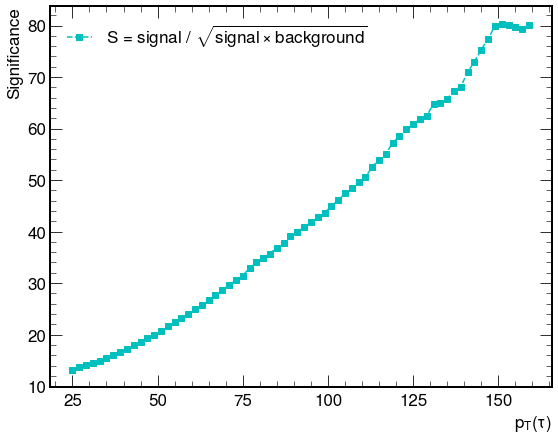

In [11]:
pt_min = 25
pt_max = 160
arr_pt = np.arange(pt_min, pt_max, 2)



sign1 = np.array([pt_tau_cut(Df_1000GeV_cut, val = i).shape[0] * w[1] \
          / ((pt_tau_cut(Df_bgw_cut, val = i).shape[0]* w[3]) +
             (pt_tau_cut(Df_bgz_cut, val = i).shape[0] * w[4])) ** 0.5 \
         for i in arr_pt])

print(sign1[-5], arr_pt[-5], sep =', ')
#print(pt_tau_cut(Df_bgw_cut, val = i).shape[0])
#print(pt_tau_cut(Df_bgw_cut, val = i).shape[0]* w[3])
plt.figure(figsize=(9,7))
plt.plot(arr_pt, sign1,'cs--', label = r"S = signal / $\sqrt{signal \times background}$")
plt.ylabel('Significance', fontsize= 17)
plt.xlabel(r'$p_T(\tau)$', fontsize= 17)
plt.legend(fontsize= 17)
plt.xticks(fontsize= 17)
plt.yticks(fontsize= 17);

In [12]:
#Applying cuts over the data 
opt = 150
Df_600GeV_cut = final_cuts(Df_600GeV, pt_tau = opt, pt_b=30, del_phi = 0, met = 0)
Df_1000GeV_cut = final_cuts(Df_1000GeV, pt_tau = opt, pt_b=30, del_phi = 0, met = 0)
Df_1600GeV_cut = final_cuts(Df_1600GeV, pt_tau = opt, pt_b=30, del_phi = 0, met = 0)
Df_bgw_cut = final_cuts(Df_bg_wj, pt_tau = opt, pt_b=30, del_phi = 0, met = 0)
Df_bgz_cut = final_cuts(Df_bg_zj, pt_tau = opt, pt_b=30, del_phi = 0, met = 0)

In [13]:
#Efficiency
print(Df_1000GeV_cut.shape[0]/ Df_1000GeV.shape[0])
print(Df_bgw_cut.shape[0] / Df_bg_wj.shape[0])
print(Df_bgz_cut.shape[0] / Df_bg_zj.shape[0])

0.619001386962552
0.008982661374556089
0.010124135124135123


130.44521624332512, 1.7000000000000002


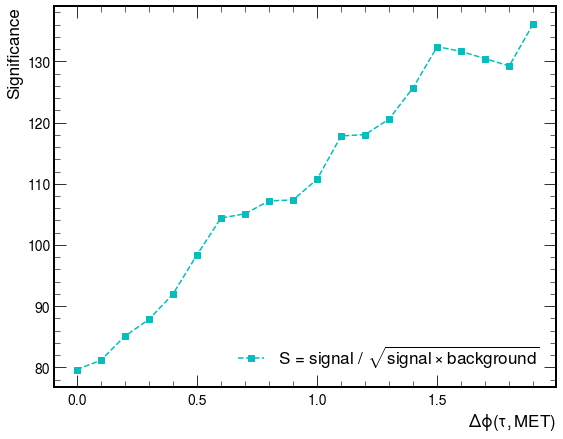

In [14]:
del_phi_min = 0
del_phi_max = 2.0
arr_dp = np.arange(del_phi_min, del_phi_max, 0.1)



#print(pt_tau_cut(Df_bgw_cut, val = 214).shape[0]* w[3])

sign2 = np.array([phi_tau_cut(Df_1000GeV_cut, val = i).shape[0] * w[1] \
          / ((phi_tau_cut(Df_bgw_cut, val = i).shape[0]* w[3]) + 
             (phi_tau_cut(Df_bgz_cut, val = i).shape[0] * w[4])) ** 0.5 \
         for i in arr_dp])

print(sign2[-3], arr_dp[-3], sep =', ')
plt.figure(figsize=(9,7))
plt.plot(arr_dp, sign2,'cs--', label = r"S = signal / $\sqrt{signal \times background}$")
plt.ylabel('Significance', fontsize= 17)
plt.xlabel(r'$\Delta\phi(\tau,MET)$', fontsize= 17)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14);
plt.legend(loc = 'lower right', fontsize= 17);

In [15]:
opt = 150
odp = 2.0
Df_600GeV_cut = final_cuts(Df_600GeV, pt_tau = opt, pt_b=30, del_phi = odp, met = 0)
Df_1000GeV_cut = final_cuts(Df_1000GeV, pt_tau = opt, pt_b=30, del_phi = odp, met = 0)
Df_1600GeV_cut = final_cuts(Df_1600GeV, pt_tau = opt, pt_b=30, del_phi = odp, met = 0)
Df_bgw_cut = final_cuts(Df_bg_wj, pt_tau = opt, pt_b=30, del_phi = odp, met = 0)
Df_bgz_cut = final_cuts(Df_bg_zj, pt_tau = opt, pt_b=30, del_phi = odp, met = 0)

In [16]:
#Eficiencies
print(Df_1000GeV_cut.shape[0]/ Df_1000GeV.shape[0])
print(Df_bgw_cut.shape[0] / Df_bg_wj.shape[0])
print(Df_bgz_cut.shape[0] / Df_bg_zj.shape[0])

0.5391123439667129
0.002297890119072488
0.0031033781033781033


461.6397874668937, 160


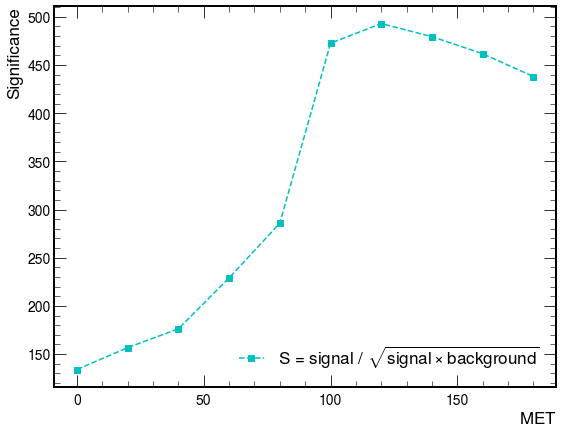

In [17]:
met_min = 0
met_max = 200
arr_dmet = np.arange(met_min, met_max, 20)


#print(pt_tau_cut(Df_bgw_cut, val = 214).shape[0]* w[3])

sign3 = np.array([et_met_cut(Df_1000GeV_cut, val = i).shape[0] * w[1] \
          / (et_met_cut(Df_bgw_cut, val = i).shape[0]* w[3] + 
             et_met_cut(Df_bgz_cut, val = i).shape[0] * w[4]) ** 0.5 \
         for i in arr_dmet])
print(sign3[-2], arr_dmet[-2], sep =', ')
plt.figure(figsize=(9,7))
plt.plot(arr_dmet, sign3,'cs--', label = r"S = signal / $\sqrt{signal \times background}$")
plt.ylabel('Significance', fontsize= 17)
plt.xlabel(r'$MET$', fontsize= 17)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14);
plt.legend(loc = 'lower right', fontsize= 17);

In [18]:
opt = 150
odp = 0.8
omet = 150
Df_600GeV_cut = final_cuts(Df_600GeV, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)
Df_1000GeV_cut = final_cuts(Df_1000GeV, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)
Df_1600GeV_cut = final_cuts(Df_1600GeV, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)
Df_bgw_cut = final_cuts(Df_bg_wj, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)
Df_bgz_cut = final_cuts(Df_bg_zj, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)

In [19]:
#Eficiencies
print(Df_1000GeV_cut.shape[0]/ Df_1000GeV.shape[0])
print(Df_bgw_cut.shape[0] / Df_bg_wj.shape[0])
print(Df_bgz_cut.shape[0] / Df_bg_zj.shape[0])

0.5306518723994452
0.0004177982034677251
0.0


In [20]:
df = pd.DataFrame(ex_ev_s, columns = ["expected_events"])
df['First_Selection'] = np.array([Df_600GeV.shape[0], Df_1000GeV.shape[0],
                                 Df_1600GeV.shape[0], Df_bg_wj.shape[0], Df_bg_zj.shape[0]]) * w 
df['Second_Selection'] = np.array([Df_600GeV_cut.shape[0], Df_1000GeV_cut.shape[0],
                                 Df_1600GeV_cut.shape[0], Df_bgw_cut.shape[0], Df_bgz_cut.shape[0]]) * w 
df

,expected_events,First_Selection,Second_Selection
S600GeV,45.731400,3.094644e+05,87575.63100
S1000GeV,6.063200,4.371567e+04,23197.80320
S1600GeV,0.886600,6.421644e+03,4390.44320
Bg_WJ,2035.404855,9.743483e+06,4070.80971
Bg_ZJ,140.279246,2.757329e+06,0.00000


# ***Plotting***

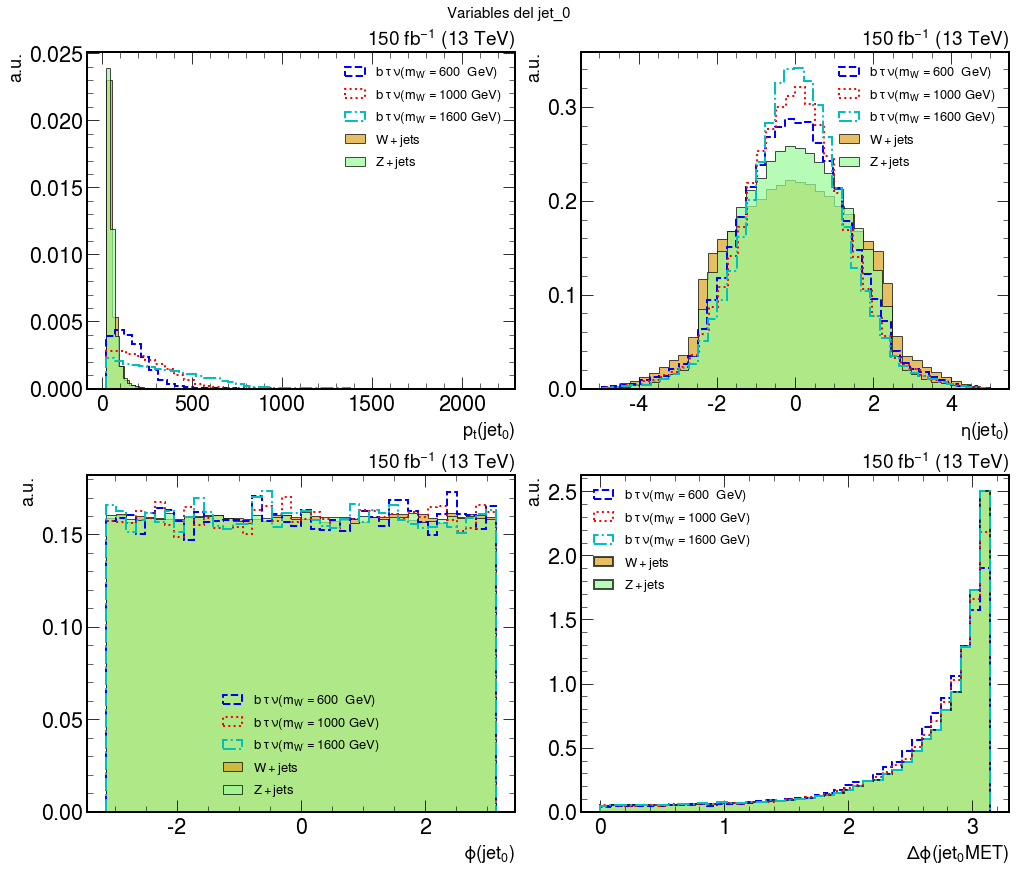

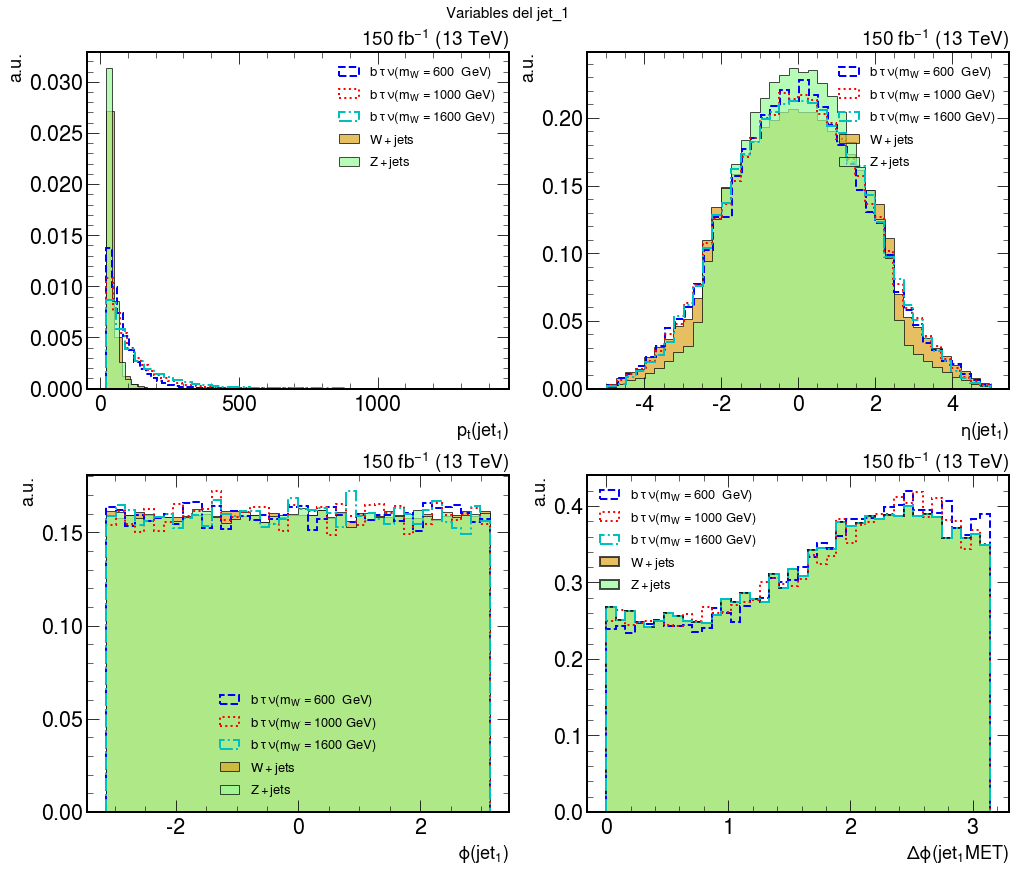

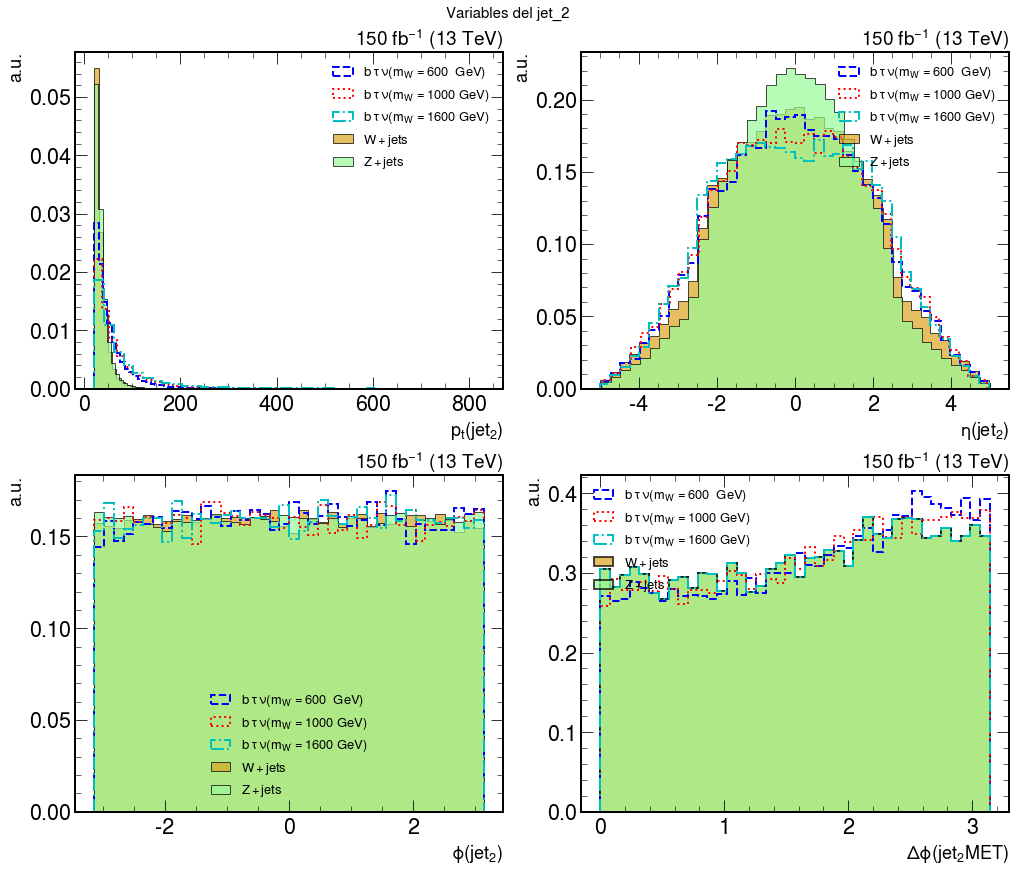

In [21]:
#PT, eta, phi and delta phi with Met for the i = 3 first jets

labs1 = [r"$b\,\tau\,\nu$($m_{W'} = 600$  GeV)",
        r"$b\,\tau\,\nu$($m_{W'} = 1000$ GeV)", 
        r"$b\,\tau\,\nu$($m_{W'} = 1600$ GeV)",
         "$W+$jets",
         "$Z+$jets"]
colo1 = ['b', 'r', 'c', 'goldenrod', 'palegreen']
colo2 = ['g', 'k', 'm']
lineas1 = ["--", ":", "-."]
w2 = df.Second_Selection
w1 = df.First_Selection

for j in range(3):
  plot_pt_eta_phi1(labels= labs1 ,colors=colo1 , lines= lineas1, df1 =df_600Gev,df2 =df_1000Gev,df3 =df_1600Gev ,
                   bg1 = df_bg_wj, bg2 = df_bg_zj, i = j, nbins=40)

/home/tomas/Documentos/VirtualEnv/primer_entorno/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/tomas/Documentos/VirtualEnv/primer_entorno/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


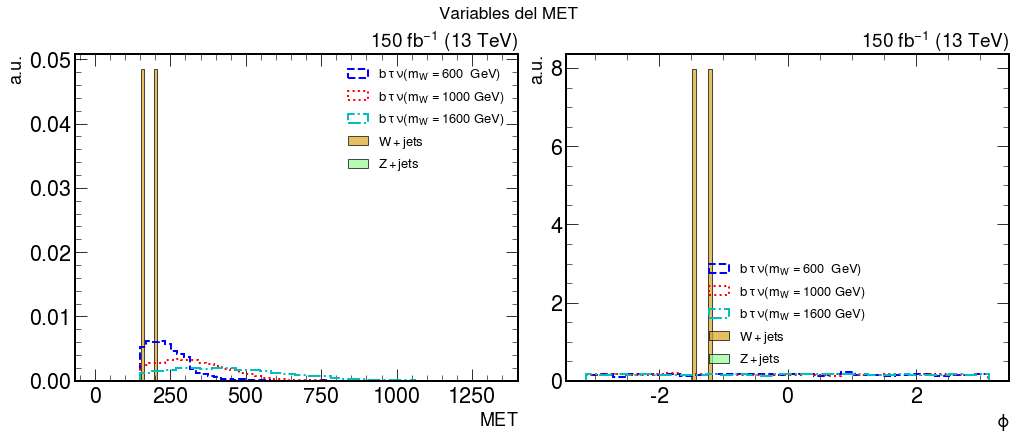

In [22]:
plot_Met_ET_Phi2(Df_600GeV_cut, Df_1000GeV_cut, Df_1600GeV_cut, 
                 Df_bgw_cut, Df_bgz_cut,labs1, colo1, lineas1, 30, 5)

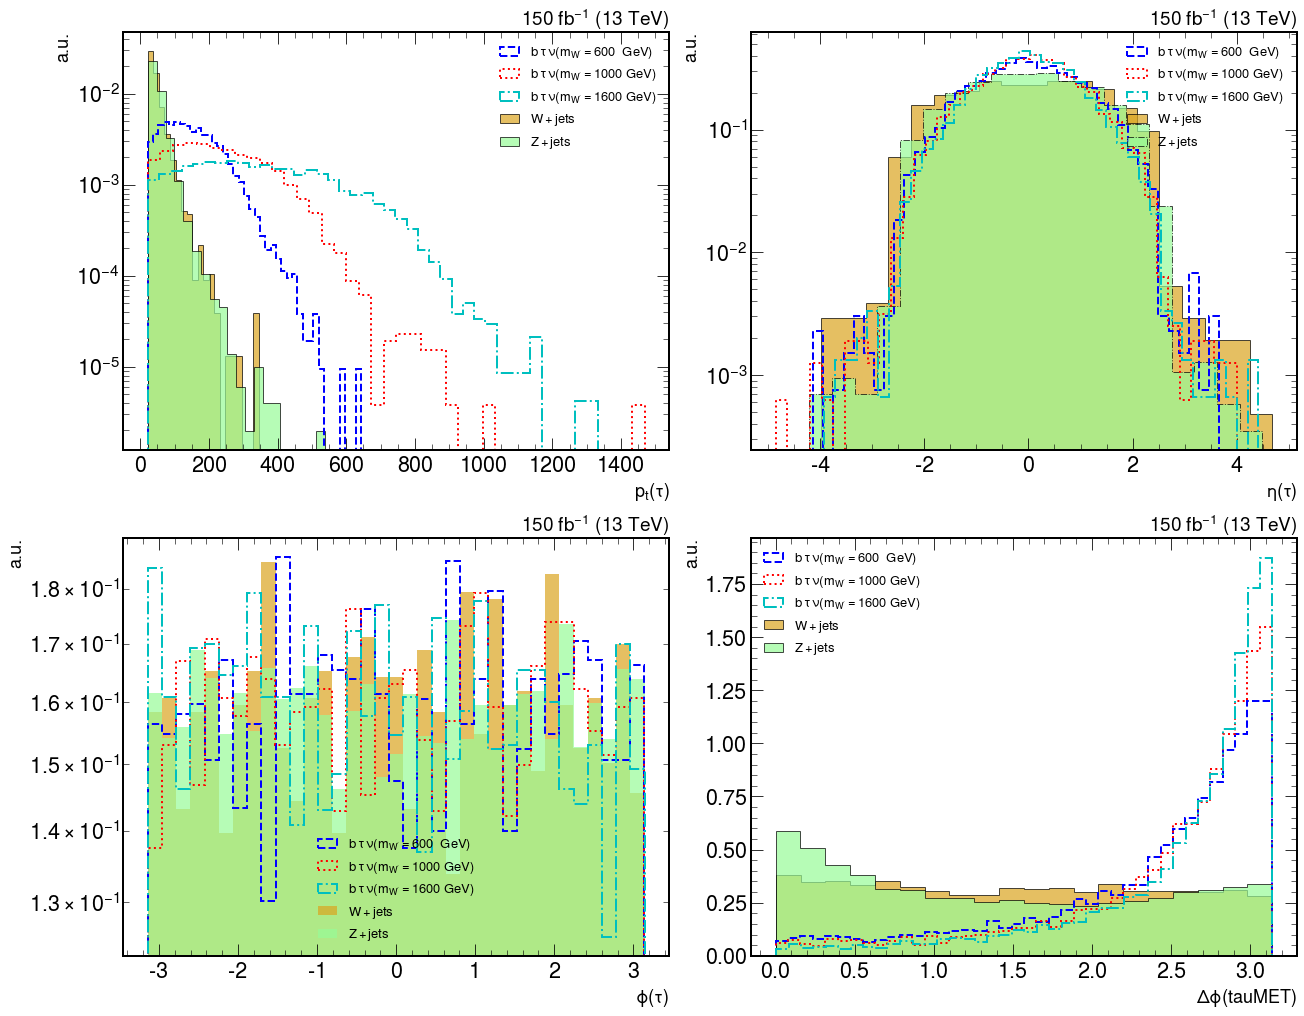

In [23]:
#Pt Eta phi and delta phi with met for the tau
plot_pt_eta_phi2(labels= labs1, colors= colo1,
                 lines= lineas1, obj = "tau", df1 = Df_600GeV, 
                 df2 = Df_1000GeV, df3 = Df_1600GeV,
                 bg1 = Df_bg_wj, bg2 = Df_bg_zj )

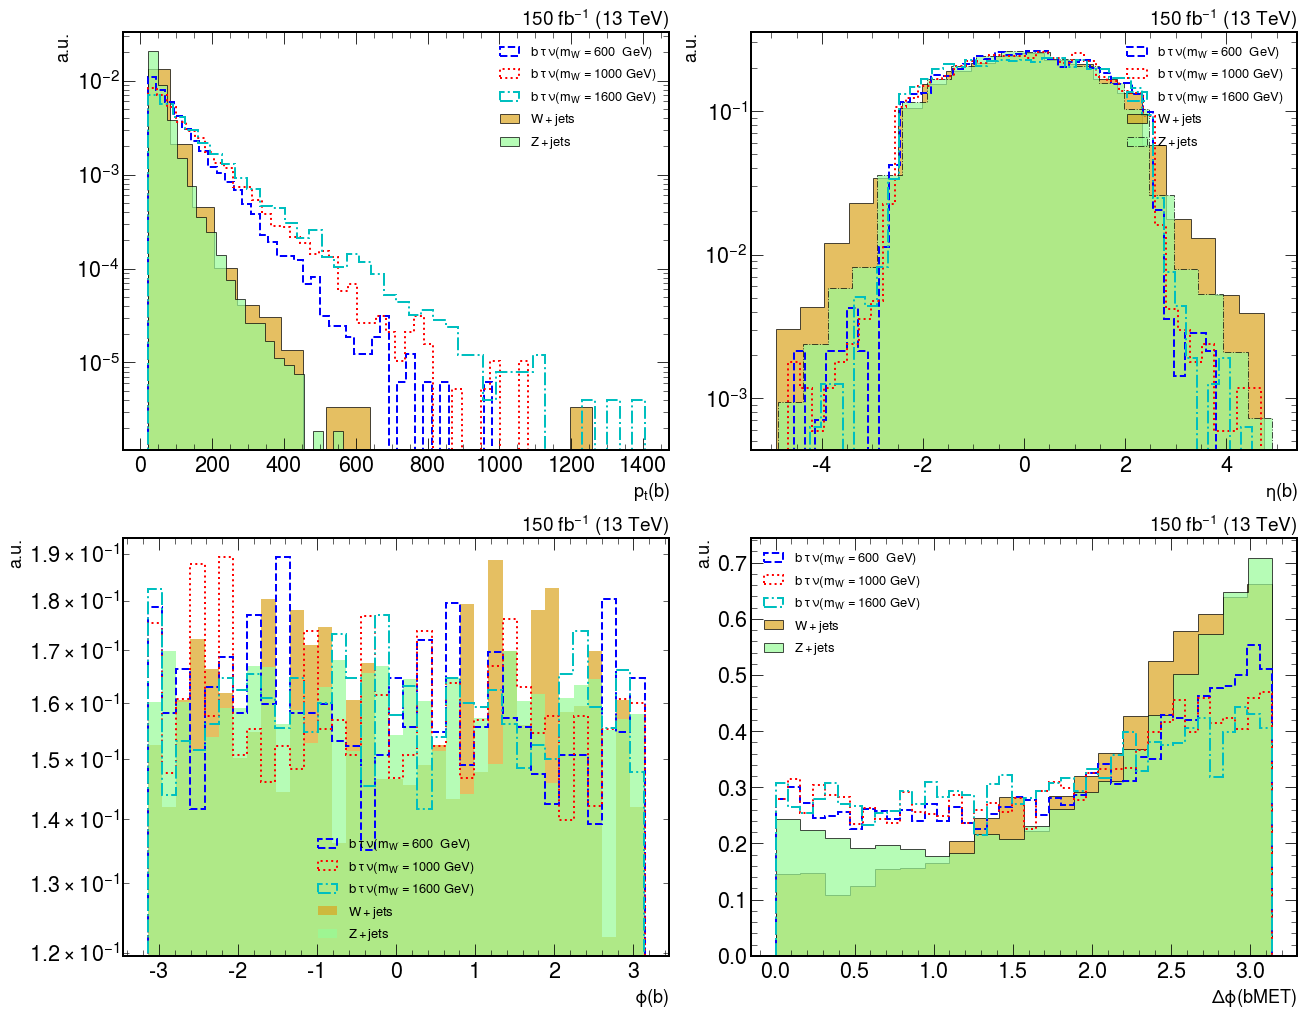

In [25]:
#Pt Eta phi and delta phi with met for the tau
plot_pt_eta_phi2(labels= labs1, colors= colo1,
                 lines= lineas1, obj = "b", df1 = Df_600GeV, 
                 df2 = Df_1000GeV, df3 = Df_1600GeV,
                 bg1 = Df_bg_wj, bg2 = Df_bg_zj )

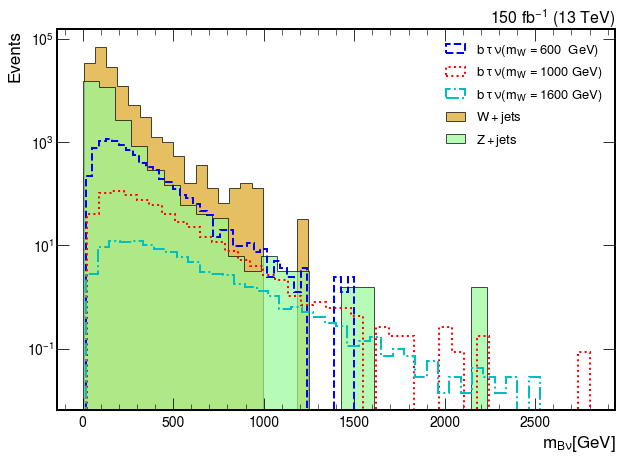

In [26]:
m_tau_b1 = generate_ploteable_invariant_masses(Df_600GeV,Df_1000GeV, Df_1600GeV)
m_inv_BgZ = invariant_mass(Df_bg_zj.tau_pT, Df_bg_zj.tau_eta, Df_bg_zj.b_pT, Df_bg_zj.b_eta, Df_bg_zj.Delta_phi_B_Met)
m_inv_BgW = invariant_mass(Df_bg_wj.tau_pT, Df_bg_wj.tau_eta, Df_bg_wj.b_pT, Df_bg_wj.b_eta, Df_bg_wj.Delta_phi_B_Met)

#Invariant Mass between tau, b
plot_mass1(labels= labs1, colors= colo1, lines = lineas1, 
           mass_type= r'$m_{B \nu}[GeV]$', m1= m_tau_b1[0], 
           m2 =m_tau_b1[1], m3 =m_tau_b1[2], m_bg1 = m_inv_BgW,
           Weights = w1, m_bg2 = m_inv_BgZ, bins_bg =[20,25])

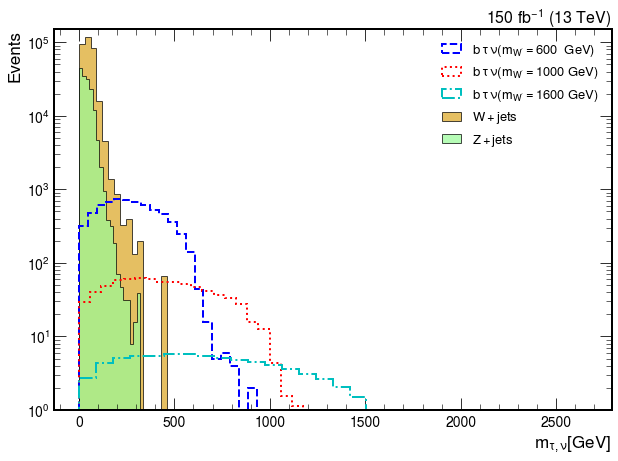

In [28]:
#Transverse mass of tau without cuts
m_trvs_tau_nu1 = generate_ploteable_tr_tau_nu_masses(Df_600GeV,Df_1000GeV, Df_1600GeV)
m_trvs_BgZ = transverse_mass(Df_bg_zj.tau_pT, Df_bg_zj.met_Met, Df_bg_zj.Delta_phi_Tau_Met)
m_trvs_BgW = transverse_mass(Df_bg_wj.tau_pT, Df_bg_wj.met_Met, Df_bg_wj.Delta_phi_Tau_Met)


#m_tr_tau_bg1 = transverse_mass(Df_bg.tau_pT,Df_bg.met_Met,Df_bg.Delta_phi_Tau_Met)
plot_mass1(labels= labs1, colors= colo1, lines = lineas1, 
           mass_type= r'$m_{\tau, \nu}[GeV]$', m1 = m_trvs_tau_nu1[0], m2 = m_trvs_tau_nu1[1], 
           m3 = m_trvs_tau_nu1[2], m_bg1 = m_trvs_BgW, m_bg2 = m_trvs_BgZ,
           Weights = w1, nbins = 30, bins_bg =[15,18])
plt.ylim(1, 1.5e5);
#plt.xlim(0,2000);

/home/tomas/Documentos/VirtualEnv/primer_entorno/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


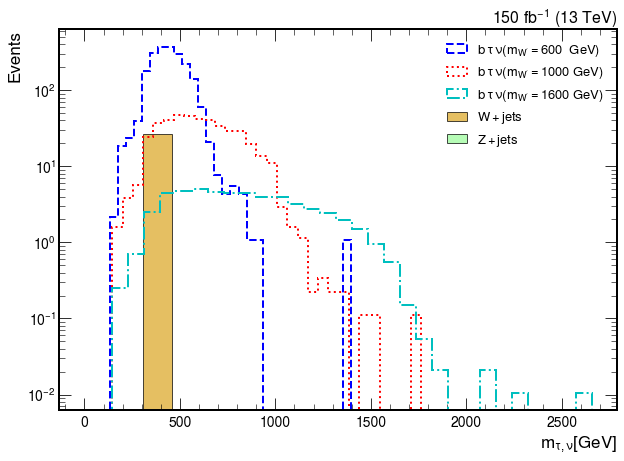

In [29]:
#Transverse mass of tau with cuts
m_trvs_tau_nu2 = generate_ploteable_tr_tau_nu_masses(Df_600GeV_cut,Df_1000GeV_cut, Df_1600GeV_cut)
m_trvs_BgW_cut = transverse_mass(Df_bgw_cut .tau_pT, Df_bgw_cut.met_Met, Df_bgw_cut.Delta_phi_Tau_Met)
m_trvs_BgZ_cut = transverse_mass(Df_bgz_cut .tau_pT, Df_bgz_cut.met_Met, Df_bgz_cut.Delta_phi_Tau_Met)

plot_mass1(labels= labs1, colors= colo1, lines = lineas1, 
           mass_type= r'$m_{\tau, \nu}[GeV]$', m1 = m_trvs_tau_nu2[0], m2 = m_trvs_tau_nu2[1], 
           m3 = m_trvs_tau_nu2[2], m_bg1 = m_trvs_BgW_cut,
           Weights = w2, m_bg2 = m_trvs_BgZ_cut, nbins = 30, bins_bg = ['auto', 'auto'])
#plt.ylim(1, 4e2);
#plt.xlim(0,2000);

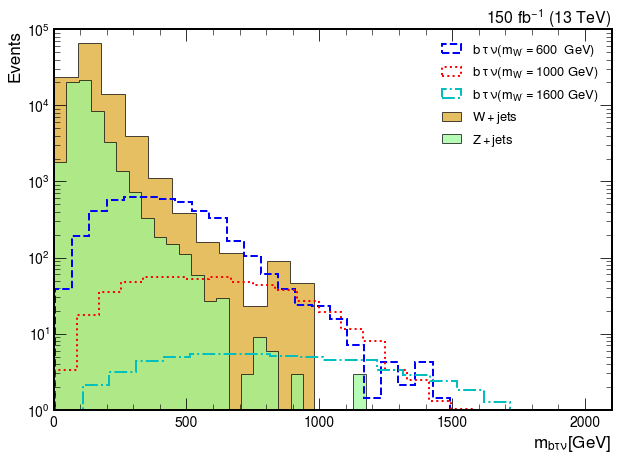

In [30]:
#Total mass between b tau nu without cuts
m_T1 = generate_ploteable_total_masses(Df_600GeV, Df_1000GeV, Df_1600GeV)
m_T_bg_Z1 = Df_bg_zj.apply(m_Tot, axis = 1)
m_T_bg_W1 = Df_bg_wj.apply(m_Tot, axis = 1)
plot_mass1(labels= labs1, colors= colo1, lines = lineas1,
           mass_type = r'$m_{b \tau \nu}[GeV]$', m1 = m_T1[0],
           m2 = m_T1[1], m3 = m_T1[2], m_bg1 = m_T_bg_W1, m_bg2 = m_T_bg_Z1 ,
           Weights = w1, nbins = 31,bins_bg = [25, 25])
plt.ylim(1, 1e5)
plt.xlim(0,2100);

/home/tomas/Documentos/VirtualEnv/primer_entorno/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


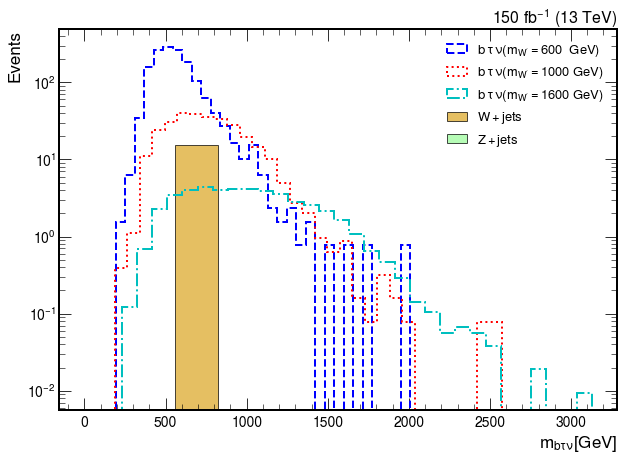

In [31]:
#Total mass without b tau nu with cuts
m_T1 = generate_ploteable_total_masses(Df_600GeV_cut, Df_1000GeV_cut, Df_1600GeV_cut)
m_T_bg_Z2 = Df_bgz_cut.apply(m_Tot, axis = 1)
m_T_bg_W2 = Df_bgw_cut.apply(m_Tot, axis = 1)

plot_mass1(labels= labs1, colors= colo1, lines = lineas1,
           mass_type = r'$m_{b \tau \nu}[GeV]$', m1 = m_T1[0],
           m2 = m_T1[1], m3 = m_T1[2], m_bg1 = m_T_bg_W2, m_bg2 = m_T_bg_Z2 ,
           Weights = w2, nbins = 31, bins_bg = ['auto', 'auto'])
#plt.ylim(1, 4e2);
#plt.xlim(0,2200);

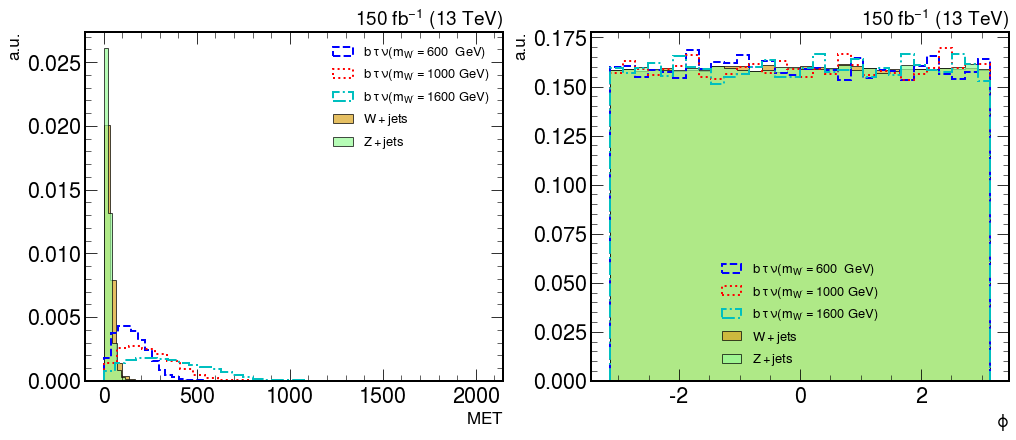

In [25]:
#Delta phi 
plot_Met_ET_Phi1(df_600Gev, df_1000Gev, df_1600Gev, 
                 df_bg_wj, df_bg_zj,labs1, colo1, lineas1, 30, 30)

In [2]:
#K factor
NLO_EW_mup = [2988.2, 2988.2, 2988.01, 2988.4,
             2987.7, 2899.0, 2898.33, 2898.37, 2898.18]
NLO_EW_mum = [2076.48, 2076.51, 2076.62, 2076.9, 2076.0]

kf = (np.mean(NLO_EW_mup) + np.mean(NLO_EW_mum)) / 6342 
kf 

0.7923001506710117

In [3]:
np.mean(NLO_EW_mup) + np.mean(NLO_EW_mum)

5024.767555555556